# LSTM 

> Fill in a module description here

In [ ]:
# | default_exp lstm

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from ts_vae_lstm.concepts import get_window
from scipy import signal
import os
import math
import torch

In [ ]:
num_workers = os.cpu_count()

torch.backends.mkldnn.enabled = False
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers, device

/home/gg/.local/share/virtualenvs/ts_vae-lstm-hz-Oy2CQ/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


(4, 'cpu')

Train a VAE with no anomalies in the time series.

```--> Anomalies occur at:
  timestamp #0: 2014-11-01 19:00:00
  timestamp #1: 2014-11-27 15:30:00
  timestamp #2: 2014-12-25 15:00:00
  timestamp #3: 2015-01-01 01:00:00
  timestamp #4: 2015-01-27 00:00:00

Original csv file contains (10320,) timestamps.
Processed time series contain (10320,) readings.
Anomaly indices are [5943, 7184, 8527, 8835, 10081]

Training set mean is 14855.115757575757
Training set std is 6556.134705703313
Anomaly indices in the test set are [2643 3884 5227 5535 6781]```

In [ ]:
# | export
load_dotenv()

BASEDIR = os.getenv("BASEDIR")
MODELDIR = os.getenv("MODELDIR")

In [ ]:
data = np.load(f"{BASEDIR}/sample_data/nyc_taxi.npz")
df = pd.DataFrame(data["training"], index=data["t_train"], columns=["value"])
df.head(2)

,value
1,-0.647416
2,-1.048144


In [ ]:
# | export

from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# | export
from ts_vae_lstm.vae import VAE, Encoder, Decoder, StochasticSampler
from fastcore.xtras import noop

t
t_unit
readings
idx_anomaly
idx_split
training
test
train_m
train_std
t_train
t_test
idx_anomaly_test


Take `k` embeddings and predict the next `k` embeddings.

In [ ]:
vae_model = torch.load(f"{MODELDIR}/vae_100_z24.pth", map_location="cpu")

using non-overlapping windows this time!

In [ ]:
# window_size = 10  # predict 10*30=300 minutes ahead
p = (
    48
    # so that one window is one day and the model can predict ahead one day
)

data = [
    {
        "subset": get_window(
            df.values,
            window_size=p,
            end_step=t,
            indices=list(df.index),
            return_indices=False,
        ),
        "end_step": t,
        "start_step": t - p,
    }
    for t in range(
        p, len(df), p
    )  # take steps every 48 so that we end up with non-overlapping sequences
]

In [ ]:
len(data)

114

We want to predict only the `t+1` and not the horizon. 
$$[\hat{e}_{2_t}, \cdots, \hat{e}_{k_t}] = \text{LSTM}([e_{1_t}, \cdots, e_{k-1_t}])$$


In [ ]:
# | export
@torch.no_grad()
def get_embeddings(x, n_windows=1, latent_dim=32, seq_len=1, sampler_repeat=200):
    """
    _summary_

    Parameters
    ----------
    x : _type_
        _description_
    n_windows : int, optional
        _description_, by default 1
    latent_dim : int, optional
        _description_, by default 32
    seq_len : int, optional
        _description_, by default 1
    sampler_repeat : int, optional
        Number of times to repeatedly sample from the sampler to ensure we have enough variablity in the embedding, by default 10

    Returns
    -------
    _type_
        _description_
    """
    # actual_shape = x.shape[0]
    vae_model.eval()
    x = torch.from_numpy(x.astype(np.float32)).view(
        n_windows, -1, seq_len
    )  # p, seq -> n_windows, p, seq
    embedded_x = torch.zeros(n_windows, latent_dim, seq_len)
    for idx in range(n_windows):
        batched_x_window = x[idx].unsqueeze(0)
        # print(batched_x_window.shape)
        z_mean, z_log_var = vae_model.encoder(batched_x_window)
        # print(z_mean.shape, z_log_var.shape)
        for _ in range(sampler_repeat):
            # explore multiple potential future embeddings by sampling from the latent space multiple times (Monte Carlo sampling).
            embedded_x[idx] += (
                vae_model.latent_sampler(z_mean, z_log_var).permute(1, 0)
                / sampler_repeat
            )
    # reshape
    embedded_x = embedded_x.reshape(latent_dim * n_windows, -1)
    return embedded_x  # is of shape (n_windows* latent_dim, seq_len)

In [ ]:
data[0]["subset"].shape

(48, 1)

In [ ]:
get_embeddings(data[0]["subset"], latent_dim=24, sampler_repeat=1).shape

torch.Size([24, 1])

In [ ]:
data_embeddings = [
    {
        "subset": get_embeddings(
            data[i]["subset"],
            latent_dim=24,
            n_windows=1,
            seq_len=1,
            sampler_repeat=1,  # large number would mean we get the average embedding of the latent space
        ),
        "end_step": data[i]["end_step"],
        "start_step": data[i]["start_step"],
    }
    for i in range(len(data))
]

Reduce Sampling: Experiment with a smaller number of samples (e.g., 10 or 20) to see if it preserves more information in the embeddings while still providing some robustness.

Alternative Aggregation: Instead of averaging, consider other aggregation methods like taking the median or using a weighted average based on the reconstruction loss of each sample.

In [ ]:
len(data_embeddings)

114

In [ ]:
data_embeddings[0]["subset"].shape

torch.Size([24, 1])

### With the sampled avg embeddings, can we reconstruct the signal?

In [ ]:
idx = 1
x_emb_sampled = data_embeddings[idx]["subset"]
x_true_signal = data[idx]["subset"]
x_emb_sampled.shape, x_true_signal.shape

(torch.Size([24, 1]), (48, 1))

In [ ]:
x_emb_sampled = x_emb_sampled.unsqueeze(0)
x_emb_sampled.shape

torch.Size([1, 24, 1])

In [ ]:
x_true_signal = torch.from_numpy(x_true_signal).unsqueeze(0)
x_true_signal.shape

torch.Size([1, 48, 1])

### Split the dataset
- last 20% of the dataset from this for validation
- preserve the order of the dataset, ie the next window is the target

In [ ]:
# dont include last index as this will cause value error
np.random.seed(42)
range_choices = range(len(data_embeddings) - 1)
# val_split_idx = len(data_embeddings) - int(0.2 * len(data_embeddings))
# print(f"split validation set from {val_split_idx}")
# val_data_idxs = [idx for idx in range_choices if idx >= val_split_idx]

val_data_idxs = np.random.choice(
    range_choices, size=int(0.2 * len(data_embeddings)), replace=False
)

# indices for current window and next window
val_data_idxs = [idx for idx in val_data_idxs]
print(f"validation indices are: {val_data_idxs}")
len(val_data_idxs)

validation indices are: [80, 4, 40, 69, 10, 45, 70, 66, 47, 11, 98, 36, 83, 111, 18, 0, 72, 26, 81, 53, 104, 91]


22

In [ ]:
# val_data_idxs_curr_windows = [idx[0] for idx in val_data_idxs]
trn_data_idxs = [idx for idx in range_choices if idx not in val_data_idxs]
print(f"train indices are: {trn_data_idxs}")
len(trn_data_idxs)

train indices are: [1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 71, 73, 74, 75, 76, 77, 78, 79, 82, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 112]


91

Labels (next window) is  not used for training or loss calculation so this should be fine.

### Get statistics of embeddings (train)

Mean of training data to standardize the embeddings. These are global statistics for the train set.

In [ ]:
window_means = np.asarray(
    [data_embeddings[i]["subset"].mean().item() for i in trn_data_idxs]
)
window_stds = np.asarray(
    [data_embeddings[i]["subset"].std().item() for i in trn_data_idxs]
)
emb_mean, emb_std = window_means.mean(), window_stds.mean()
emb_mean, emb_std

(0.11468668954170586, 0.9908110839979989)

Check if validation set haas similar statistics as train.

In [ ]:
val_window_means = np.asarray(
    [data_embeddings[i]["subset"].mean().item() for i in val_data_idxs]
)
val_window_stds = np.asarray(
    [data_embeddings[i]["subset"].std().item() for i in val_data_idxs]
)
val_emb_mean, val_emb_std = val_window_means.mean(), val_window_stds.mean()
val_emb_mean, val_emb_std

(0.12414250634372531, 1.0413747321475635)

## Prepare Dataset

In [ ]:
# | export


class TSLSTMDataset(Dataset):
    def __init__(
        self,
        embeddings,  # full dataset (not separated as we need to index the next window)
        indices,
        # window_size=48,
        # latent_dim=32,
        # n_features=1,
        # n_prev_windows=1,
        mean=0,
        std=1,
    ):
        self.embeddings = embeddings
        self.indices = indices  # (idx, idx+1) pairs)
        self.mean = mean
        self.std = std
        # self.n_prev_windows = n_prev_windows
        # self.window_size = window_size
        # self.n_features = n_features
        # self.latent_dim = latent_dim

    def __getitem__(self, idx):
        xidx = self.indices[idx]
        # per-window statistics could be anopter way to do this.
        seq_emb = (self.embeddings[xidx]["subset"] - self.mean) / self.std
        x_emb = seq_emb[:-1]
        y_emb = seq_emb[1:]
        assert len(x_emb) == len(y_emb)
        return x_emb, y_emb  # latent_dim, seq_len

    def __len__(self):
        return len(self.indices)

In [ ]:
means, stds = emb_mean, emb_std  # 0, 1
dset_trn = TSLSTMDataset(
    data_embeddings,
    indices=trn_data_idxs,
    mean=means,
    std=stds,
)

dset_val = TSLSTMDataset(
    data_embeddings,
    indices=val_data_idxs,
    mean=means,
    std=stds,
)  # use same stats from training data

In [ ]:
# verify if loading works for all indices
x_emb, y_emb = [dset_trn[i] for i in range(len(dset_trn))][0]
x_emb, y_emb = [dset_val[i] for i in range(len(dset_val))][0]

In [ ]:
x_emb.shape, y_emb.shape, y_emb.device, x_emb.requires_grad, y_emb.requires_grad

(torch.Size([23, 1]), torch.Size([23, 1]), device(type='cpu'), False, False)

In [ ]:
x_emb.mean(), y_emb.mean()

(tensor(0.2614), tensor(0.1528))

### Embedding sampling possibly flawed

The embdeddings for the same dataset will be differnt (if we pass x to the get_embedding function in two different calls within the train dataset. Here we avoid this by generating embeddings in advance and storing it) due to the Stochastic Sampling layer in VAE. The sampler_repeat argument in the function to get emdeddings repeats the sampling process with same input and takes an average.

Maybe having this variation is useful to help make the models robust.


In [ ]:
x_emb.flatten()

tensor([-0.5837, -0.4937,  1.3533, -1.1379,  0.3974,  1.2274,  0.8661,  2.4056,
         2.0085,  0.3498, -1.1256, -0.8863, -0.5743, -1.1553,  0.2187,  1.2033,
        -0.4904,  0.4139,  1.1080, -0.1505, -0.4136,  2.0718, -0.6001])

In [ ]:
y_emb.flatten()

tensor([-0.4937,  1.3533, -1.1379,  0.3974,  1.2274,  0.8661,  2.4056,  2.0085,
         0.3498, -1.1256, -0.8863, -0.5743, -1.1553,  0.2187,  1.2033, -0.4904,
         0.4139,  1.1080, -0.1505, -0.4136,  2.0718, -0.6001, -3.0830])

In [ ]:
batch_size = 8

In [ ]:
dl_trn = DataLoader(
    dataset=dset_trn,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=num_workers,
)
dl_val = DataLoader(
    dataset=dset_val,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=num_workers,
)

In [ ]:
xs, ys = next(iter(dl_trn))

In [ ]:
xs.shape

torch.Size([8, 23, 1])

In [ ]:
# | export
class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size=32,
        hidden_size=128,
        output_size=32,
        activation=F.mish,
        bidirectional=True,
    ):
        super(LSTMModel, self).__init__()
        self.isz = input_size
        self.hsz = hidden_size
        self.osz = output_size
        self.lstm_input = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,  # output_size,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=1,
        )
        self.lstm_hidden = nn.LSTM(
            input_size=hidden_size * 2
            if bidirectional
            else hidden_size,  # output_size,
            hidden_size=hidden_size * 2 if bidirectional else hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=1,
        )
        self.lstm_output = nn.LSTM(
            input_size=hidden_size * 4 if bidirectional else hidden_size,
            hidden_size=output_size,
            num_layers=1,
            batch_first=True,
        )
        self.ln1 = nn.LayerNorm(hidden_size * 2 if bidirectional else hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size * 4 if bidirectional else hidden_size)
        self.activation = activation
        self.dropout = nn.Dropout(0.5)
        self._init_lstm_weights()

    def forward(self, x):
        # x has shape bs, emb_dim, seq_len (emb_dim=latent_dim, seq_len=1)
        x = x.permute(0, 2, 1)  # bs, seq_len, emb_dim
        # LSTM1
        lstm_out1, _ = self.lstm_input(x)
        lstm_out1 = self.dropout(self.activation(self.ln1(lstm_out1)))
        # print(lstm_out1.shape)
        # LSTM2
        lstm_out2, _ = self.lstm_hidden(lstm_out1)
        lstm_out2 = self.dropout(self.activation(self.ln2(lstm_out2)))
        # LSTM3
        lstm_out3, _ = self.lstm_output(lstm_out2)
        return lstm_out3.permute(0, 2, 1)  # bs, output_size, seq_len

    def _init_lstm_weights(self):
        for layer in [self.lstm_input, self.lstm_hidden, self.lstm_output]:
            for name, param in layer.named_parameters():
                if "weight" in name:
                    nn.init.xavier_normal_(param)
                elif "bias" in name:
                    nn.init.constant_(param, 0.0)

In [ ]:
xs.shape, ys.shape

(torch.Size([8, 23, 1]), torch.Size([8, 23, 1]))

In [ ]:
lstm_model = LSTMModel(
    input_size=23,
    output_size=23,
    hidden_size=128,
).to(device)
pred_ys = lstm_model(xs.to(device))

pred_ys.shape

torch.Size([8, 23, 1])

# Training loop

In [ ]:
def embedding_loss(emb1, emb2, dim=1):
    """
    Calculate the embedding loss as the MAE.

    Parameters
    ----------
    emb1 : _type_
        _description_
    emb2 : _type_
        _description_
    """
    return torch.mean(torch.mean(torch.abs(emb1.cpu() - emb2.cpu()), dim=dim))

In [ ]:
embedding_loss(pred_ys, ys)

tensor(0.4367, grad_fn=<MeanBackward0>)

In [ ]:
@torch.no_grad()
def embedding_metric(emb1, emb2, reduce=True, dim=1):
    # Jaccard Similarity or Sørensen–Dice coefficient ?
    # avg per embedding dimension the metric, ie: [4, emb, 1] -> [4, 1]
    scores = {
        "mae": torch.mean(torch.abs(emb1.cpu() - emb2.cpu()), dim=dim),
        "cos_sim": F.cosine_similarity(emb1.cpu(), emb2.cpu(), dim=dim),
    }

    if reduce:
        for k, v in scores.items():
            scores[k] = torch.mean(v).item()  # mean loss per batch
    return scores

In [ ]:
embedding_metric(pred_ys, ys, reduce=False)["cos_sim"]

tensor([[0.8058],
        [0.8141],
        [0.8230],
        [0.8633]])

In [ ]:
embedding_metric(pred_ys, ys)["cos_sim"]

0.8265724778175354

In [ ]:
embedding_metric(pred_ys, ys, reduce=False)["mae"]

tensor([[0.3985],
        [0.5316],
        [0.3544],
        [0.4623]])

In [ ]:
embedding_metric(pred_ys, ys)["mae"]

0.4367002844810486

In [ ]:
# | export
from fastcore.xtras import partial

Epoch [1/100], Batch [22/22], Loss: [0.782, 0.788], Score: [0.176, 0.352]
Epoch [2/100], Batch [22/22], Loss: [0.722, 0.784], Score: [0.374, 0.369]
Epoch [3/100], Batch [22/22], Loss: [0.697, 0.744], Score: [0.426, 0.461]
Epoch [4/100], Batch [22/22], Loss: [0.685, 0.759], Score: [0.464, 0.427]
Epoch [5/100], Batch [22/22], Loss: [0.665, 0.729], Score: [0.501, 0.487]
Epoch [6/100], Batch [22/22], Loss: [0.649, 0.730], Score: [0.544, 0.489]
Epoch [7/100], Batch [22/22], Loss: [0.658, 0.716], Score: [0.518, 0.513]
Epoch [8/100], Batch [22/22], Loss: [0.637, 0.724], Score: [0.551, 0.510]
Epoch [9/100], Batch [22/22], Loss: [0.647, 0.723], Score: [0.542, 0.505]
Epoch [10/100], Batch [22/22], Loss: [0.642, 0.724], Score: [0.541, 0.515]
Epoch [11/100], Batch [22/22], Loss: [0.623, 0.713], Score: [0.582, 0.531]
Epoch [12/100], Batch [22/22], Loss: [0.606, 0.711], Score: [0.611, 0.536]
Epoch [13/100], Batch [22/22], Loss: [0.610, 0.716], Score: [0.596, 0.515]
Epoch [14/100], Batch [22/22], Los

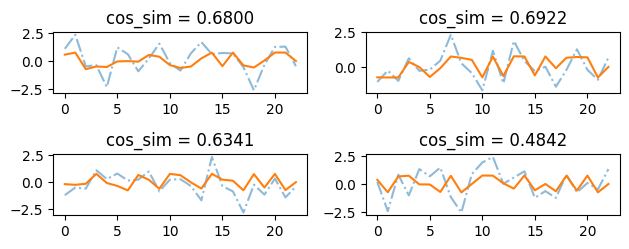

Epoch [20/100], Batch [22/22], Loss: [0.582, 0.675], Score: [0.643, 0.601]
Epoch [21/100], Batch [22/22], Loss: [0.586, 0.685], Score: [0.635, 0.593]
Epoch [22/100], Batch [22/22], Loss: [0.583, 0.689], Score: [0.649, 0.588]
Epoch [23/100], Batch [22/22], Loss: [0.578, 0.680], Score: [0.650, 0.601]
Epoch [24/100], Batch [22/22], Loss: [0.574, 0.683], Score: [0.651, 0.587]
Epoch [25/100], Batch [22/22], Loss: [0.575, 0.693], Score: [0.653, 0.579]
Epoch [26/100], Batch [22/22], Loss: [0.574, 0.713], Score: [0.643, 0.550]
Epoch [27/100], Batch [22/22], Loss: [0.575, 0.716], Score: [0.637, 0.548]
Epoch [28/100], Batch [22/22], Loss: [0.564, 0.676], Score: [0.661, 0.607]
Epoch [29/100], Batch [22/22], Loss: [0.577, 0.687], Score: [0.633, 0.581]
Epoch [30/100], Batch [22/22], Loss: [0.560, 0.684], Score: [0.678, 0.582]
Epoch [31/100], Batch [22/22], Loss: [0.559, 0.697], Score: [0.671, 0.567]
Epoch [32/100], Batch [22/22], Loss: [0.559, 0.690], Score: [0.667, 0.565]
Epoch [33/100], Batch [22

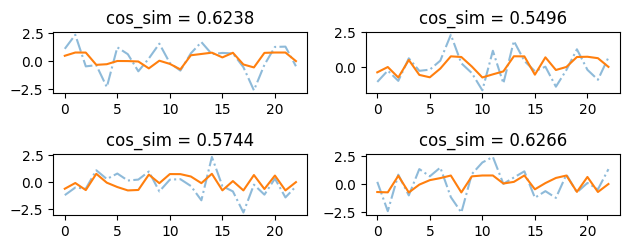

Epoch [40/100], Batch [22/22], Loss: [0.535, 0.683], Score: [0.699, 0.585]
Epoch [41/100], Batch [22/22], Loss: [0.561, 0.670], Score: [0.659, 0.598]
Epoch [42/100], Batch [22/22], Loss: [0.545, 0.683], Score: [0.683, 0.585]
Epoch [43/100], Batch [22/22], Loss: [0.542, 0.682], Score: [0.695, 0.586]
Epoch [44/100], Batch [22/22], Loss: [0.537, 0.685], Score: [0.696, 0.579]
Epoch [45/100], Batch [22/22], Loss: [0.526, 0.700], Score: [0.702, 0.574]
Epoch [46/100], Batch [22/22], Loss: [0.538, 0.690], Score: [0.695, 0.593]
Epoch [47/100], Batch [22/22], Loss: [0.526, 0.686], Score: [0.711, 0.597]
Epoch [48/100], Batch [22/22], Loss: [0.537, 0.700], Score: [0.698, 0.575]
Epoch [49/100], Batch [22/22], Loss: [0.541, 0.689], Score: [0.695, 0.597]
Epoch [50/100], Batch [22/22], Loss: [0.520, 0.684], Score: [0.719, 0.595]
Epoch [51/100], Batch [22/22], Loss: [0.525, 0.666], Score: [0.717, 0.624]
Epoch [52/100], Batch [22/22], Loss: [0.527, 0.676], Score: [0.708, 0.614]
Epoch [53/100], Batch [22

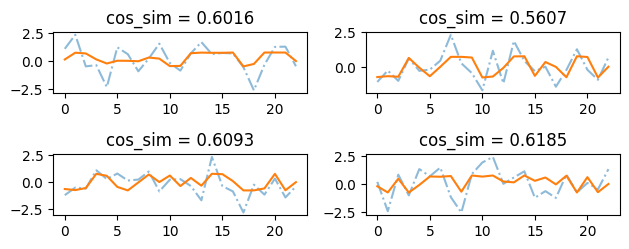

Epoch [60/100], Batch [22/22], Loss: [0.516, 0.670], Score: [0.730, 0.614]
Epoch [61/100], Batch [22/22], Loss: [0.513, 0.668], Score: [0.721, 0.614]
Epoch [62/100], Batch [22/22], Loss: [0.511, 0.669], Score: [0.730, 0.613]
Epoch [63/100], Batch [22/22], Loss: [0.501, 0.667], Score: [0.745, 0.612]
Epoch [64/100], Batch [22/22], Loss: [0.503, 0.673], Score: [0.737, 0.609]
Epoch [65/100], Batch [22/22], Loss: [0.507, 0.677], Score: [0.735, 0.605]
Epoch [66/100], Batch [22/22], Loss: [0.504, 0.668], Score: [0.736, 0.605]
Epoch [67/100], Batch [22/22], Loss: [0.495, 0.669], Score: [0.749, 0.609]
Epoch [68/100], Batch [22/22], Loss: [0.505, 0.663], Score: [0.741, 0.614]
Epoch [69/100], Batch [22/22], Loss: [0.504, 0.656], Score: [0.741, 0.616]
Epoch [70/100], Batch [22/22], Loss: [0.499, 0.662], Score: [0.746, 0.611]
Epoch [71/100], Batch [22/22], Loss: [0.498, 0.656], Score: [0.745, 0.626]
Epoch [72/100], Batch [22/22], Loss: [0.496, 0.653], Score: [0.753, 0.640]
Epoch [73/100], Batch [22

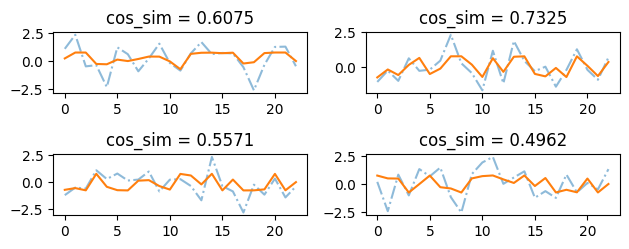

Epoch [80/100], Batch [22/22], Loss: [0.493, 0.687], Score: [0.749, 0.597]
Epoch [81/100], Batch [22/22], Loss: [0.481, 0.689], Score: [0.767, 0.602]
Epoch [82/100], Batch [22/22], Loss: [0.477, 0.692], Score: [0.771, 0.594]
Epoch [83/100], Batch [22/22], Loss: [0.489, 0.677], Score: [0.750, 0.613]
Epoch [84/100], Batch [22/22], Loss: [0.473, 0.668], Score: [0.775, 0.623]
Epoch [85/100], Batch [22/22], Loss: [0.483, 0.678], Score: [0.759, 0.610]
Epoch [86/100], Batch [22/22], Loss: [0.468, 0.666], Score: [0.783, 0.624]
Epoch [87/100], Batch [22/22], Loss: [0.482, 0.671], Score: [0.756, 0.619]
Epoch [88/100], Batch [22/22], Loss: [0.484, 0.662], Score: [0.755, 0.637]
Epoch [89/100], Batch [22/22], Loss: [0.472, 0.659], Score: [0.780, 0.636]
Epoch 00089: reducing learning rate of group 0 to 4.8600e-03.
Epoch [90/100], Batch [22/22], Loss: [0.478, 0.664], Score: [0.767, 0.628]
Epoch [91/100], Batch [22/22], Loss: [0.481, 0.664], Score: [0.763, 0.620]
Epoch [92/100], Batch [22/22], Loss: [

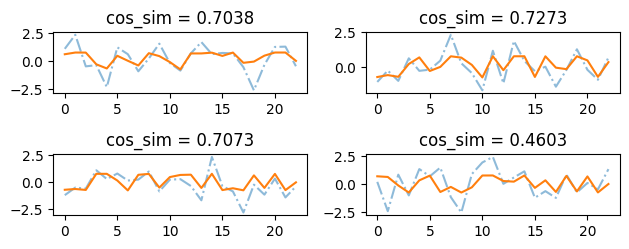

Epoch [100/100], Batch [22/22], Loss: [0.474, 0.661], Score: [0.764, 0.630]


In [ ]:
batch_size = 4
num_epochs = 100
learning_rate = 6e-3

latent_dim = 24
input_size = latent_dim - 1
output_size = input_size
hidden_size = 64  # int(latent_dim * 3)

activation = F.gelu
criterion = embedding_loss
scorer = embedding_metric
metric_name = "cos_sim"

means, stds = emb_mean, emb_std

dset_trn = TSLSTMDataset(
    data_embeddings,
    indices=trn_data_idxs,
    mean=means,
    std=stds,
)

dset_val = TSLSTMDataset(
    data_embeddings,
    indices=val_data_idxs,
    mean=means,
    std=stds,
)  # use same stats from training data


dl_trn = DataLoader(
    dataset=dset_trn,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=num_workers,
)
dl_val = DataLoader(
    dataset=dset_val,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=num_workers,
)
train_dataloader = dl_trn
valid_dataloader = dl_val

model = LSTMModel(
    input_size=input_size,
    output_size=output_size,
    hidden_size=hidden_size,
    activation=activation,
).to(device)


optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-6,
)

# Training loop

print_every = len(train_dataloader)

# Define LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.9,
    patience=15,
    min_lr=1e-8,
    verbose=True,
)


# validation


def validate_epoch(dls, criterion, scorer, show=False):
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    n_dls = 0  # due to droplast, make sure to divide by correct batch_size
    with torch.no_grad():
        for batch_idx, (xs, ys) in enumerate(dls):
            # move to device
            xs = xs.to(device)
            ys = ys.to(device)

            # Forward pass
            pred_ys = model(xs)

            loss = criterion(pred_ys, ys)
            # calc score
            score = scorer(pred_ys, ys)[metric_name]

            running_loss += loss.item()
            running_score += score
            n_dls += 1
        if show:
            for idx in range(batch_size):
                ax = plt.subplot(4, 2, idx + 1)
                pred_ys_idx, ys_idx = (
                    pred_ys[idx].detach().cpu().squeeze(),
                    ys[idx].detach().cpu().squeeze(),
                )
                sns.lineplot(ys_idx.numpy(), alpha=0.5, linestyle="-.", ax=ax)
                sns.lineplot(pred_ys_idx.numpy(), ax=ax)
                score_idx = scorer(pred_ys, ys, reduce=False)[metric_name][idx].item()
                plt.title(f"{metric_name} = {score_idx:.4f}")
            plt.tight_layout()
            plt.show()

    return running_loss / n_dls, running_score / n_dls


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_score = 0.0
    n_dls = 0  # due to droplast, make sure to divide by correct batch_size
    for batch_idx, (xs, ys) in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        # move to device
        xs = xs.to(device)
        ys = ys.to(device)

        # Forward pass
        pred_ys = model(xs)

        loss = criterion(pred_ys, ys)
        # calc score
        score = scorer(pred_ys, ys)[metric_name]

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_score += score
        n_dls += 1
    # epoch ended
    if (batch_idx + 1) % print_every == 0:
        # calculate loss for valid_dataloader
        # n_dls = len(train_dataloader)
        val_loss, val_score = validate_epoch(
            valid_dataloader, criterion, scorer, show=(epoch + 1) % 20 == 0
        )
        print(
            "Epoch [{}/{}], Batch [{}/{}], Loss: [{:.3f}, {:.3f}], Score: [{:.3f}, {:.3f}]".format(
                epoch + 1,
                num_epochs,
                batch_idx + 1,
                n_dls,
                running_loss / n_dls,
                val_loss,
                running_score / n_dls,
                val_score,
            )
        )
    # reset at end of epoch
    running_loss = 0.0
    running_score = 0.0
    # Step the LR scheduler
    scheduler.step(val_loss)  # min the running_loss

In [ ]:
model_path = f"{MODELDIR}/lstm_{num_epochs}.pth"
model_path

'/run/media/data2/ts_vae-lstm/models/lstm_100.pth'

In [ ]:
torch.save(model, model_path)

# Inference

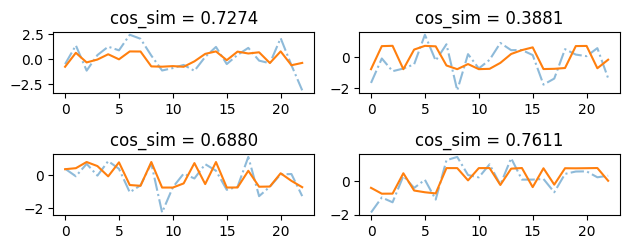

In [ ]:
with torch.no_grad():
    model.eval()
    metric_name = "cos_sim"
    xs_val, ys_val = next(iter(valid_dataloader))
    pred_ys_val = model(xs_val.to(device))
    score = scorer(pred_ys_val, ys_val, reduce=False)[metric_name]

    for idx in range(batch_size):
        if idx >= 8:
            break
        ax = plt.subplot(4, 2, idx + 1)
        score_idx = score[idx].item()
        pred_ys_idx, ys_idx = (
            pred_ys_val[idx].detach().cpu().squeeze(),
            ys_val[idx].detach().cpu().squeeze(),
        )
        sns.lineplot(ys_idx.numpy(), alpha=0.5, linestyle="-.", ax=ax)
        sns.lineplot(pred_ys_idx.numpy(), ax=ax)
        plt.title(f"{metric_name} = {score_idx:.4f}")
    plt.tight_layout()
    plt.show()

# Reconstruct the time series 
Take the predicted embedding, pass it to the decoder of VAE to make the prediction.

In [ ]:
pred_ys_idx.shape, ys_idx.shape

(torch.Size([23]), torch.Size([23]))

But since offset by 1, concat at the beginning one emb from `xs_idx`.

In [ ]:
def concat_first_emb(y_emb, first_emb):
    """Concat first_emb to y_emb"""
    return torch.concat([first_emb, y_emb])

In [ ]:
pred_ys_idx_concat = concat_first_emb(pred_ys_idx, xs[idx][0])
ys_idx_concat = concat_first_emb(ys_idx, xs[idx][0])
pred_ys_idx_concat.shape, ys_idx_concat.shape

(torch.Size([24]), torch.Size([24]))

In [ ]:
pred_ts_values = vae_model.decoder(pred_ys_idx_concat.unsqueeze(0))
pred_ts_values_true = vae_model.decoder(ys_idx_concat.unsqueeze(0))

In [ ]:
pred_ts_values.shape

torch.Size([1, 48, 1])

In [ ]:
F.mse_loss(pred_ts_values, pred_ts_values_true)

tensor(0.0452, grad_fn=<MseLossBackward0>)

Plot time series values decoded from embedding. This assumes that VAE pred is the ground truth, which may not be absolutely true.

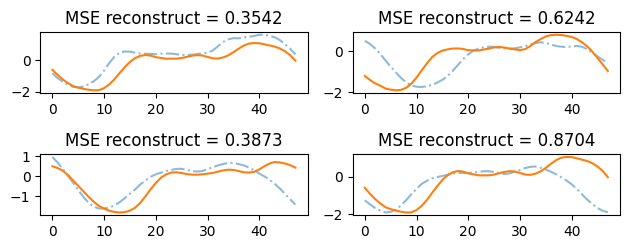

In [ ]:
with torch.no_grad():
    model.eval()
    metric_name = "cos_sim"
    xs_val, ys_val = next(iter(valid_dataloader))
    pred_ys_val = model(xs_val.to(device))

    for idx in range(batch_size):
        if idx >= 8:
            break
        ax = plt.subplot(4, 2, idx + 1)

        pred_ys_idx, ys_idx, xs_idx = (
            pred_ys_val[idx].detach().cpu().squeeze(),
            ys_val[idx].detach().cpu().squeeze(),
            xs_val[idx].detach().cpu(),  # xs should be a tensor of 1 item
        )
        # concat first embedding of xs to make it match in latent_dim=24
        pred_ys_idx_concat = concat_first_emb(pred_ys_idx, xs_idx[0])
        ys_idx_concat = concat_first_emb(ys_idx, xs_idx[0])
        # reconstruct time series
        pred_ts_values = vae_model.decoder(pred_ys_idx_concat.unsqueeze(0)).squeeze()
        ts_values_true = vae_model.decoder(ys_idx_concat.unsqueeze(0)).squeeze()
        # reconstructed time series score
        mse_val = F.mse_loss(pred_ts_values, ts_values_true)
        # plot
        sns.lineplot(ts_values_true.numpy(), alpha=0.5, linestyle="-.", ax=ax)
        sns.lineplot(pred_ts_values.numpy(), ax=ax)
        plt.title(f"MSE reconstruct = {mse_val:.4f}")
    plt.tight_layout()
    plt.show()

In [ ]:
torch.abs(pred_ts_values - pred_ts_values_true).mean()

tensor(1.0254, grad_fn=<MeanBackward0>)

### Reconstruction
- can rescale with mean and std to get back in original scale of embedding
- learn the mean and variance rather than the embedding itself

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()